# How to determine the cuisine of a given recipe #

**Business understanding - main objective if the analysis**

A researcher named Yong-Yeol Ahn scraped tens of thousands of food recipes (cuisines and ingredients) from different websites. For more information on Yong-Yeol Ahn and his research, you can read his paper on Flavor Network and the Principles of Food Pairing: http://yongyeol.com/papers/ahn-flavornet-2011.pdf.

The main objective of the analysis is to predict the cuisine in each observation (recipe) based on the ingredients. A secondary objective is to understand if some ingredients are specific of the most popular cusines.

**Business Goal**

It is a data-driven investigation to open new avenues in a systematic understanding of culinary practice. Researchers raised the question whether there are any general patterns that determine the ingredient combinations used in food, which trascend the individual tastes and recipes. 


**Summary and key findings**

Along the analysis of the data I found that the original dataset is unbalanced due to the prominent precence of recipes for the America cuisine, which share more than 70% of the data. As consequence I decided to balance the recipes using imbalanced-learn and cross validation to test 3 different startegies among which I selected SMOTE. Using the over-sampled dataset I wento into the bottleneck of peocessing power which lead me to accept a 2 folded compromise which is functional to the exercise: reduce the labels by means of removing the cuisines which has less than 1000 recipes in the original dataset, and run under-sampling on top of the now balanced dataset. 

I could classify the top 5 ingredients for the top cuisines, and viceversa. You can see the tables in cells 9 and 10.

I chose the f1 score as metric because it summarizes well the precision and recall measures. I run different classification models, and for each one I calculated the f1 score and plotted the confusion matrix.

I run a simple Logistic Regression to set a baseline on the original un-balanced dataset, and un-surprisingly the f1 score was poor: 0.6788. I verified that simply reducing the labels would bring up the f1 score above 0.8.

Next I run the models using the finally balanced dataset:

| Model | F1 score | 
| --- | --- | 
| Logisitic regression + GridSearchCV (solver) | 0.8164 | 
| Logisitc regression CV with regularization + GridSearchCV (penalty) | 0.8177 | 
| KNN, looped over to find the optimal n_neighbors) | 0.8026 | 
| Decision Tree + GridSearchCV (max_depth and max_features) | 0.8338 | 
| Random Forest, looped over to find the optimal n_trees | 0.8683 | 

It looks like the best classifier model is Random Forest. 

I was impressed by the fact that the regularization didn't add much to the score, and that the f1 score didn't hit the .9 - 1 range. I explain this fact as a consequence of the over and under sampling, which both possibly affected the precision and consequently the F1 score.

I do think that possible improvements can happen with an activity to data in an originally balanced dataset. It could also be possible to work to a taxonomy which groups cuisines in homogeneous groups bringing to a lower number of meaningful labels.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
import math
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
from colorsetup import colors, palette #course module

# imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

**Brief description of the data**

Our dataset consists of 57,691 recipes. Each observation represents a recipe, and for each recipe the corresponding cuisine is documented as well as whether 384 ingredients exist in the recipe or not, beginning with almond and ending with zucchini.

Initial plan for data exploration, the dataset is stored in a csv file:

- check the schema: snake case style, all lowercase
- basic info: data types, null values, any missing values to replace
- shape: total number of recipes 57,691, 384 ingredients, 69 different cuisines
- check format of the data and naming conventions
- verify need to scale data, standardize, normalize
- verify need for binning, one hot encoding
- descriptive statistics: check any bias between cuisines and ingredients

Actions taken for data cleaning and feature engineering:
- updated column country into cuisine
- updated all cuisines to lower case
- standardized cuisines names (e.g. Japan into Japanese)
- aggregated some cuisines (e.g. Italian + Italy into Italian)
- encoded ingredients Yes/No to 0/1 for ML, and the labels
- removed the cuisines with less than 1000 recipes
- reducing the American cuisine bias (40,150 recipes, Mexico second with 1,754)

**ETL**

In [2]:
filepath = 'recipes.csv'

# set folder to data if not already in
if os.listdir()[0] != filepath:
    os.chdir('data')

# read the csv file in a dataframe
try:
    recipes = pd.read_csv(filepath)
    print('Shape of the dataset: {}'.format(recipes.shape))
except Exception as e:
    print(e)

# show 2 sample observations    
recipes.sample(2)

Shape of the dataset: (57691, 385)


,Unnamed: 0,country,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,blue_cheese,blueberry,bone_oil,bourbon_whiskey,brandy,brassica,bread,broccoli,brown_rice,brussels_sprout,buckwheat,butter,buttermilk,cabbage,cabernet_sauvignon_wine,cacao,camembert_cheese,cane_molasses,caraway,cardamom,carnation,carob,carrot,cashew,cassava,catfish,cauliflower,caviar,cayenne,celery,celery_oil,cereal,chamomile,champagne_wine,chayote,cheddar_cheese,cheese,cherry,cherry_brandy,chervil,chicken,chicken_broth,chicken_liver,chickpea,chicory,chinese_cabbage,chive,cider,cilantro,cinnamon,citrus,citrus_peel,clam,clove,cocoa,coconut,coconut_oil,cod,coffee,cognac,concord_grape,condiment,coriander,corn,corn_flake,corn_grit,cottage_cheese,crab,cranberry,cream,cream_cheese,cucumber,cumin,cured_pork,currant,date,dill,durian,eel,egg,egg_noodle,elderberry,emmental_cheese,endive,enokidake,fennel,fenugreek,feta_cheese,fig,fish,flower,frankfurter,fruit,galanga,gardenia,garlic,gelatin,geranium,gin,ginger,goat_cheese,grape,grape_brandy,grape_juice,grapefruit,green_bell_pepper,green_tea,gruyere_cheese,guava,haddock,ham,hazelnut,herring,holy_basil,honey,hop,horseradish,huckleberry,jamaican_rum,japanese_plum,jasmine,jasmine_tea,juniper_berry,kaffir_lime,kale,katsuobushi,kelp,kidney_bean,kiwi,kohlrabi,kumquat,lamb,lard,laurel,lavender,leaf,leek,lemon,lemon_juice,lemon_peel,lemongrass,lentil,lettuce,licorice,lilac_flower_oil,lima_bean,lime,lime_juice,lime_peel_oil,lingonberry,litchi,liver,lobster,long_pepper,lovage,macadamia_nut,macaroni,mace,mackerel,malt,mandarin,mandarin_peel,mango,maple_syrup,marjoram,mate,matsutake,meat,melon,milk,milk_fat,mint,mozzarella_cheese,mung_bean,munster_cheese,muscat_grape,mushroom,mussel,mustard,mutton,nectarine,nira,nut,nutmeg,oat,oatmeal,octopus,okra,olive,olive_oil,onion,orange,orange_flower,orange_juice,orange_peel,oregano,ouzo,oyster,palm,papaya,parmesan_cheese,parsley,parsnip,passion_fruit,pea,peach,peanut,peanut_butter,peanut_oil,pear,pear_brandy,pecan,pelargonium,pepper,peppermint,peppermint_oil,pimenta,pimento,pineapple,pistachio,plum,popcorn,porcini,pork,pork_liver,pork_sausage,port_wine,potato,potato_chip,prawn,prickly_pear,provolone_cheese,pumpkin,quince,radish,raisin,rapeseed,raspberry,raw_beef,red_algae,red_bean,red_kidney_bean,red_wine,rhubarb,rice,roasted_almond,roasted_beef,roasted_hazelnut,roasted_meat,roasted_nut,roasted_peanut,roasted_pecan,roasted_pork,roasted_sesame_seed,romano_cheese,root,roquefort_cheese,rose,rosemary,rum,rutabaga,rye_bread,rye_flour,saffron,sage,sake,salmon,salmon_roe,sassafras,sauerkraut,savory,scallion,scallop,sea_algae,seaweed,seed,sesame_oil,sesame_seed,shallot,sheep_cheese,shellfish,sherry,shiitake,shrimp,smoke,smoked_fish,smoked_salmon,smoked_sausage,sour_cherry,sour_milk,soy_sauce,soybean,soybean_oil,spearmint,squash,squid,star_anise,starch,strawberry,strawberry_jam,strawberry_juice,sturgeon_caviar,sumac,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
55799,55799,Mexico,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,

In [3]:
# drop unnamed column
recipes.drop(['Unnamed: 0'], axis=1, inplace=True)

# rename country into cuisine
recipes.rename(columns={'country':'cuisine'}, inplace=True)

I look at the cuisines names in order to understand if they need to be standardized.

In [4]:
# show cuisines unique names
np.sort(recipes.cuisine.unique())

array(['African', 'American', 'Asian', 'Austria', 'Bangladesh', 'Belgium',
       'Cajun_Creole', 'Canada', 'Caribbean', 'Central_SouthAmerican',
       'China', 'Chinese', 'East-African', 'Eastern-Europe',
       'EasternEuropean_Russian', 'English_Scottish', 'France', 'French',
       'German', 'Germany', 'Greek', 'India', 'Indian', 'Indonesia',
       'Iran', 'Irish', 'Israel', 'Italian', 'Italy', 'Japan', 'Japanese',
       'Jewish', 'Korea', 'Lebanon', 'Malaysia', 'Mediterranean',
       'Mexican', 'Mexico', 'MiddleEastern', 'Moroccan', 'Netherlands',
       'North-African', 'Pakistan', 'Philippines', 'Portugal',
       'Scandinavia', 'Scandinavian', 'South-African', 'South-America',
       'Southern_SoulFood', 'Southwestern', 'Spain', 'Spanish_Portuguese',
       'Switzerland', 'Thai', 'Thailand', 'Turkey', 'UK-and-Ireland',
       'Vietnam', 'Vietnamese', 'West-African', 'asian', 'chinese',
       'east_asian', 'italian', 'japanese', 'korean', 'mexico', 'western'],
      dtype=o

In [5]:
# apply lower case to column names for consistency
recipes['cuisine'] = recipes.cuisine.str.lower()

# standardize cuisine names
recipes.cuisine.replace(['austria' #to replace
                        , 'china'
                        ,'east-african'
                        , 'eastern-europe'
                        , 'france'
                        , 'germany'
                        , 'india'
                        , 'indonesia'
                        , 'iran'
                        , 'italy'
                        , 'japan'
                        , 'israel'
                        , 'korea'
                        , 'mexico'
                        , 'scandinavia'
                        , 'north-african'
                        , 'south-african'
                        , 'south-america'
                        , 'spain'
                        , 'portugal'
                        , 'thailand'
                        , 'uk-and-ireland'
                        , 'irish'
                        , 'english_scottish'
                        , 'vietnam'
                        , 'west-african'
                        , 'canada'
                        , 'eastern_europe'
                        , 'easterneuropean_russian'
                        , 'southwestern'
                        , 'netherlands'
                        , 'lebanon'
                        , 'switzerland'
                        , 'turkey'
                        , 'belgium'],
                        ['austrian' #replace with
                        , 'chinese'
                        , 'east_african'
                        , 'eastern_europe'
                        , 'french'
                        , 'german'
                        , 'indian'
                        , 'indonesian'
                        , 'iranian'
                        , 'italian'
                        , 'japanese'
                        , 'jewish'
                        , 'korean'
                        , 'mexican'
                        , 'scandinavian'
                        , 'north_african'
                        , 'south_african'
                        , 'south_american'
                        , 'spanish'
                        , 'portuguese'
                        , 'thai'
                        , 'uk_irish'
                        , 'uk_irish'
                        , 'uk_scottish'
                        , 'vietnamese'
                        , 'west_african'
                        , 'canadian'
                        , 'east_european'
                        , 'east_european_russian'
                        , 'south_western'
                        , 'dutch'
                        , 'lebanese'
                        , 'swiss'
                        , 'turkish'
                        , 'belgian']
                        , inplace=True)

print('The total number of cuisines is {} after the standardization.'.format(recipes.cuisine.value_counts().shape[0]))

The total number of cuisines is 51 after the standardization.


In [6]:
# show basic information

print('data types: {}, {}\n'
      .format(recipes.dtypes.value_counts().index[0]
              , recipes.dtypes.value_counts().values[0]))

print('Null values: {}\n'
      .format(recipes.isnull().sum().any())) 

print('Ingredients are all Yes/No: {}\n'
      .format(recipes.iloc[:,1:].isin(['Yes', 'No']).sum().all()))

print('The total number of recipes is: {:,}\n'
      .format(recipes.shape[0]))

print('The total number of unique cuisines is: {}\n'
      .format(len(recipes.cuisine.unique())))

print('The total number of unique ingredients is: {}\n'
      .format(len(recipes.iloc[:,1:].columns.unique())))

data types: object, 384

Null values: False

Ingredients are all Yes/No: True

The total number of recipes is: 57,691

The total number of unique cuisines is: 51

The total number of unique ingredients is: 383



In [7]:
print('Top 10 cuisines by number of recipes, normalized:\n')
recipes.cuisine.value_counts(normalize=True)[:10]

Top 10 cuisines by number of recipes, normalized:



american     0.70
italian      0.06
mexican      0.04
french       0.02
asian        0.02
east_asian   0.02
korean       0.01
canadian     0.01
indian       0.01
western      0.01
Name: cuisine, dtype: float64

**-->Bias to address: the American cuisine shares 70% of the recipes with respect of 69 cuisines in total.**

In [8]:
print('Show descriptive statistics - most recurring ingredients (by inverted frequency of No):\n')

recipes.iloc[:,1:].describe().T.sort_values('freq')[0:10]

Show descriptive statistics - most recurring ingredients (by inverted frequency of No):



,count,unique,top,freq
egg,57691,2,No,36577
wheat,57691,2,No,36795
butter,57691,2,No,36877
onion,57691,2,No,39486
garlic,57691,2,No,40226
milk,57691,2,No,44766
vegetable_oil,57691,2,No,46502
cream,57691,2,No,47497
tomato,57691,2,No,47713
olive_oil,57691,2,No,47768


The most recurring ingredients are just a representation of the bias on the American cuisine.

In [9]:
# list top 5 ingredients by cuisine (sorted by the most recurring cuisine)

# encoding the ingredients and grouping
cuisines = recipes.replace(['No','Yes'],[0,1]).groupby('cuisine').mean()

# computing the number of recipes by cuisines for sorting
cuisines['rank'] = recipes.groupby('cuisine')['cuisine'].count().astype('int')

dim = cuisines.shape[1]
l_top_5_ingredients = []

# filling the list with dictionaries, one for each cuisine and the top ingredients
for cuisine in cuisines.index:
    top_5_arr_index = np.array(cuisines.loc[cuisine,:][0:dim-1].nlargest(5).index)
    top_5_arr_values = np.array(cuisines.loc[cuisine,:][0:dim-1].nlargest(5).round(2).values)
    d_top_5_ingredients = {'cuisine':cuisine
                           , 'rank': cuisines.loc[cuisine,'rank']
                           , '1st': top_5_arr_index[0] + ' (' + str(top_5_arr_values[0]) + ')'
                           , '2nd': top_5_arr_index[1] + ' (' + str(top_5_arr_values[1]) + ')'
                           , '3rd': top_5_arr_index[2] + ' (' + str(top_5_arr_values[2]) + ')'
                           , '4th': top_5_arr_index[3] + ' (' + str(top_5_arr_values[3]) + ')'
                           , '5th': top_5_arr_index[4] + ' (' + str(top_5_arr_values[4]) + ')'}
    l_top_5_ingredients.append(d_top_5_ingredients)

# creating the dataframe
cuisines_sorted = pd.DataFrame(l_top_5_ingredients).set_index('cuisine').sort_values('rank', ascending=False)

print('Top 5 ingredients by cuisine, sorted by the most recurring cuisine:\n')

# filtering for the 10 most important cuisines
display(cuisines_sorted[0:10])

#clean memory
del(cuisines)
del(cuisines_sorted)

Top 5 ingredients by cuisine, sorted by the most recurring cuisine:



,rank,1st,2nd,3rd,4th,5th
cuisine,,,,,,
american,40150,butter (0.41),egg (0.41),wheat (0.4),onion (0.29),milk (0.27)
italian,3250,olive_oil (0.61),garlic (0.53),tomato (0.39),onion (0.33),basil (0.31)
mexican,2390,cayenne (0.74),onion (0.68),garlic (0.62),tomato (0.59),corn (0.32)
french,1264,butter (0.5),egg (0.44),wheat (0.37),olive_oil (0.28),cream (0.27)
asian,1193,soy_sauce (0.5),ginger (0.49),garlic (0.48),rice (0.41),scallion (0.38)
east_asian,951,garlic (0.55),soy_sauce (0.5),scallion (0.5),cayenne (0.48),sesame_oil (0.39)
korean,799,garlic (0.59),scallion (0.52),cayenne (0.52),soy_sauce (0.49),sesame_oil (0.43)
canadian,774,wheat (0.4),butter (0.38),egg (0.35),onion (0.34),garlic (0.27)
indian,598,cumin (0.6),turmeric (0.51),onion (0.5),coriander (0.48),cayenne (0.47)


In [10]:
# list top 5 cuisines by ingredient (sorted by the most recurring ingredient)

# encoding the ingredients
ingredients = recipes.replace(['No','Yes'],[0,1]).groupby('cuisine').mean().T

l_top_5_cuisines = []

# filling the list with dictionaries, one for each ingredient and the top cuisines
for ingredient in ingredients.index:
    top_5_arr_index = np.array(ingredients.loc[ingredient,:].nlargest(5).index)
    top_5_arr_values = np.array(ingredients.loc[ingredient,:].nlargest(5).round(2).values)
    d_top_5_cuisines = {'ingredient':ingredient
                           , 'rank': ingredients.loc[ingredient,:].mean()
                           , '1st': top_5_arr_index[0] + ' (' + str(top_5_arr_values[0]) + ')'
                           , '2nd': top_5_arr_index[1] + ' (' + str(top_5_arr_values[1]) + ')'
                           , '3rd': top_5_arr_index[2] + ' (' + str(top_5_arr_values[2]) + ')'
                           , '4th': top_5_arr_index[3] + ' (' + str(top_5_arr_values[3]) + ')'
                           , '5th': top_5_arr_index[4] + ' (' + str(top_5_arr_values[4]) + ')'}
    l_top_5_cuisines.append(d_top_5_cuisines)

# creating the dataframe
ingredients_sorted = pd.DataFrame(l_top_5_cuisines).set_index('ingredient').sort_values('rank', ascending=False)

print('Top 5 cuisines by ingredient, sorted by the most recurring ingredient:\n')

# filtering for the 10 most important ingredients
display(ingredients_sorted[0:10])

#clean memory
del(ingredients)
del(ingredients_sorted)

Top 5 cuisines by ingredient, sorted by the most recurring ingredient:



,rank,1st,2nd,3rd,4th,5th
ingredient,,,,,,
onion,0.41,bangladesh (1.0),west_african (0.85),pakistan (0.74),cajun_creole (0.7),mexican (0.68)
garlic,0.40,pakistan (0.84),bangladesh (0.75),vietnamese (0.73),indonesian (0.67),turkish (0.62)
wheat,0.33,dutch (0.94),belgian (0.91),austrian (0.81),swiss (0.65),german (0.65)
egg,0.29,austrian (0.81),dutch (0.69),german (0.61),jewish (0.59),uk_scottish (0.53)
butter,0.28,dutch (0.78),belgian (0.73),austrian (0.71),swiss (0.7),uk_scottish (0.67)
vegetable_oil,0.25,bangladesh (1.0),pakistan (0.63),indonesian (0.5),philippines (0.49),malaysia (0.44)
cayenne,0.24,bangladesh (1.0),south_western (0.81),mexican (0.74),pakistan (0.63),west_african (0.62)
olive_oil,0.23,mediterranean (0.8),greek (0.76),moroccan (0.73),lebanese (0.65),spanish_portuguese (0.63)
black_pepper,0.22,pakistan (0.42),philippines (0.42),western (0.36),belgian (0.36),korean (0.36)


**Feature engineering**

In order to fix the American cuisine bias I will prepare the dataset removing the cuisines with less than a set number of recipes to obtain to the most significant labels for classification. I evaluate the impact to the f1 score for different levels of reductions using a simple Logistic Regression.

In [38]:
def make_cuisines(num_recipes): # num_recipes list is the threshold number of recipes to admit a cuisine
    
    '''
    The function calculates the f1 score depending by the minimum number of labels admitted to the dataset.
    It returns fetaures and labels if len(num_recipes)==1
    '''
    
    # looping between num recipes
    for num in num_recipes:
        
        # create a dataset specific to num_recipe
        recipes_num = recipes.copy()

        # remove cousines with less than num_recipe recipes
        recipes_num_index = pd.DataFrame([{i} for (i, x) 
                                    in zip(recipes.cuisine.value_counts().index, recipes.cuisine.value_counts()) 
                                    if x < num]
                                    , columns=['cuisine'])\
                                    .set_index('cuisine')

        # set recipes index to filter
        recipes_num.set_index('cuisine', inplace=True)

        # drop cuisines with less than num_recipe recipes
        recipes_num.drop(recipes_num_index.index, axis=0, inplace=True)

        # reset recipes index after removing rows
        recipes_num.reset_index(inplace=True)
        
        # encode features
        X = recipes_num.copy().replace(['No','Yes'],[0,1]).iloc[:,1:]
    

        # encode labels
        le = LabelEncoder()
        y = pd.Series(le.fit_transform(recipes_num.iloc[:,0].copy()))

        # use stratified shuffle split
        strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                                  test_size=0.3, 
                                                  random_state=0)

        # generate the train and test indexes
        train_index, test_index = next(strat_shuf_split.split(X, y))

        # generate the train datasets
        X_train = X.iloc[train_index,:]
        y_train = y.iloc[train_index]

        # generate the test datasets
        X_test  = X.iloc[test_index,:]
        y_test  = y.iloc[test_index]

        # Logistic regression object
        LE = LogisticRegression(solver='liblinear', random_state=0)

        LE.fit(X_train, y_train)

        y_pred = LE.predict(X_test)

        # show the f1 score
        print('f1 score: {}'.format(round(f1_score(y_test, y_pred, average='weighted'),4))
             , ', {} unique cuisines'.format(len(recipes_num.cuisine.unique()))
             , 'with more than {} recipes'.format(num)
             , ', {} recipes.'.format(recipes_num.shape[0]))
        
        if len(num_recipes)==1:
                return X, y, le # also return the LabelEncoder for the reverse transformation
        else:
            pass

In [12]:
# test removing cusines with less than 100, 500, 1000, and 2000 recipes
make_cuisines([100, 500, 1000, 2000])

f1 score: 0.6788 , 32 unique cuisines with more than 100 recipes , 57123 recipes.
f1 score: 0.7936 , 9 unique cuisines with more than 500 recipes , 51369 recipes.
f1 score: 0.8392 , 5 unique cuisines with more than 1000 recipes , 48247 recipes.
f1 score: 0.8802 , 3 unique cuisines with more than 2000 recipes , 45790 recipes.


**Design choice: for the sake of the exercise I decide to keep the 5 cuisines with more than 1000 recipes each.**

In [39]:
# run the function for min recipes = 1000
X, y, le = make_cuisines([1000])

f1 score: 0.8392 , 5 unique cuisines with more than 1000 recipes , 48247 recipes.


In [15]:
# compute the correlation matrix for the ingredients
corr_values = X.corr()

# setting to null all the values under the diagonal
tril_index = np.tril_indices_from(corr_values)
corr_array = np.array(corr_values)
corr_array[tril_index] = np.NaN

# create the correlation dataframe
corr_values = pd.DataFrame(corr_array, columns=corr_values.columns, index=corr_values.index)

# stacking the values
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# compute the absolute correlation 
corr_values['abs_correlation'] = corr_values.correlation.abs()

# show the features which are more than 70% correlated
corr_values[corr_values.abs_correlation > 0.7]

,feature1,feature2,correlation,abs_correlation
30938,coriander,fenugreek,0.77,0.77
31161,coriander,turmeric,0.72,0.72
36271,fenugreek,turmeric,0.89,0.89
38811,geranium,pelargonium,1.00,1.00


Very few of the 384 features show a high correlation, so I let them in.

**I now want to evaluete what's the best over-sampling strategy using imabalanced-learn. I use cross validation and a simple logisitc regression to evaluet different over-samplers.**

In [19]:
# evaluate different resamplers from imbalanced-learn using cross validation.

scores = []

# the 3 resamplers being evaluated
resamplers = [RandomOverSampler(random_state=0), SMOTE(random_state=0), ADASYN(random_state=0)]

# Stratified KFold to split the train and test data
skf = StratifiedKFold(n_splits=2)

# cross validation
for resampler in resamplers:
    score_dict = {}
    X_resampled, y_resampled = resampler.fit_resample(X, y)
    y_pred = cross_val_predict(LogisticRegression(solver='liblinear', random_state=0)
                               , X_resampled, y_resampled, cv=skf) #passing the Stratified KFold object
    score_dict['resampler'] = resampler
    score_dict['shape'] = len(y_resampled)
    score_dict['f1 score'] = f1_score(y_resampled, y_pred, average='weighted')
    score_dict['precision'] = precision_score(y_resampled, y_pred, average='weighted')
    score_dict['recall'] = recall_score(y_resampled, y_pred, average='weighted')
    scores.append(score_dict)

# showing the scores to pick up the best resampling strategy
pd.DataFrame(scores)

,resampler,shape,f1 score,precision,recall
0,RandomOverSampler(random_state=0),200750,0.78,0.78,0.78
1,SMOTE(random_state=0),200750,0.81,0.82,0.81
2,ADASYN(random_state=0),200968,0.76,0.76,0.76


**Design choice: I go with SMOTE to balance the classes and remove the America bias. Unfortunately, due to the limited processing power of my MAC, I need to under-sample for the sake of execrise. After balancing and under-sampling I end up with a number of observations in the range of the original dataset.**

In [20]:
# over-sampling
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X, y) #balanced over-sampling

# under-sampling
data = pd.concat([X_resampled, y_resampled], axis=1).sample(frac=0.25, random_state=0) #under-sampling
data.shape

(50188, 384)

In [21]:
# use train test split because the classes are now balanced

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1]
                                                    , test_size=0.3
                                                    , random_state=0)

In [40]:
def plot_confusion_matrix(y_test, y_pred, le): # le = label encoder
    
    '''
    This function plots the confusion matrix
    '''
    
    # note the inverse transformation
    labels = np.unique(le.inverse_transform(y_test))
    
    # color pallette
    sns.set_palette(sns.color_palette(colors))
    
    # plotting
    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred)
                     , annot=True
                     , fmt='d'
                     , cmap=colors
                     , annot_kws={"size": 10, "weight": "bold"})  
    
    # fine tune axes labels
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel('Ground Truth', fontsize=15)
    ax.set_ylabel('Prediction', fontsize=15)

**First classification using a simple Logistic Regression.**

In [35]:
# optimize parameters using GridSearchCV

# set parameters
param_grid = {'solver':('newton-cg', 'liblinear', 'saga'),
             'random_state': (0, 42)}

# set scoring to accuracy
GR = GridSearchCV(LogisticRegression(),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

GR.best_estimator_

LogisticRegression(random_state=0, solver='newton-cg')

f1 score: 0.8164



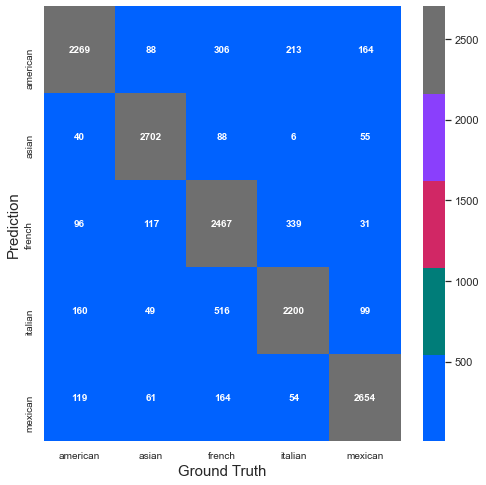

In [42]:
LE = LogisticRegression(solver='newton-cg', random_state=0)

LE.fit(X_train, y_train)

y_pred = LE.predict(X_test)

print('f1 score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

plot_confusion_matrix(y_test, y_pred, le)

**Alternative Logistics Regression with regularization.**

In [43]:
# optimize parameters using GridSearchCV for a Logistic Regression CV

# set parameters
param_grid = {'penalty':('l1', 'l2'),
             'cv': (2,3,4),
             'Cs': (0.1,1,10)}

# set scoring to accuracy
GR = GridSearchCV(LogisticRegressionCV(solver='liblinear', random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

GR.best_params_

{'Cs': 10, 'cv': 3, 'penalty': 'l1'}

In [45]:
# Use Logistics Regression CV to verify the impact of regularization

LRCV = LogisticRegressionCV(solver='liblinear', penalty='l1', Cs=100, cv=3)

LRCV.fit(X_train, y_train)

y_pred = LRCV.predict(X_test)

print('f1 score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

f1 score: 0.8177



**Second classification using Knn. I test different k and polt the f1 score.**

In [46]:
f1_scores = list()

for k in [1,2,3,5,10]: 
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred, average='weighted'), 4)))
    f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])

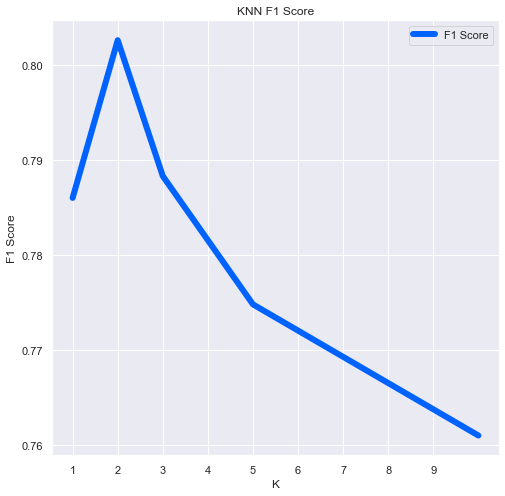

In [47]:
# plotting the f1 results
ax = f1_results.set_index('K').plot(figsize=(8, 8), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, 10, 1));
plt.title('KNN F1 Score')
plt.show()

I decide to use k=2.

f1 score: 0.8026



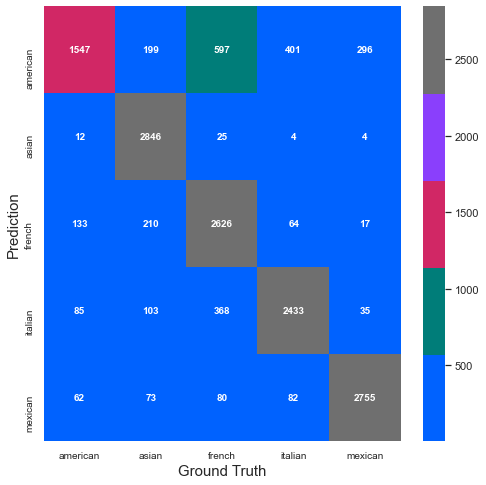

In [49]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('f1 score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

plot_confusion_matrix(y_test, y_pred, le)

**Third classification using a Decision Tree Classifier.**

In [63]:
# optimize parameters using GridSearchCV

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

# set parameters
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 20),
              'max_features': range(1, len(dt.feature_importances_)+1, 50),
             'random_state': (0, 42)}

# set scoring to accuracy
GR = GridSearchCV(dt,
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

GR.best_estimator_

DecisionTreeClassifier(max_depth=101, max_features=351, random_state=0)

f1 score: 0.8338


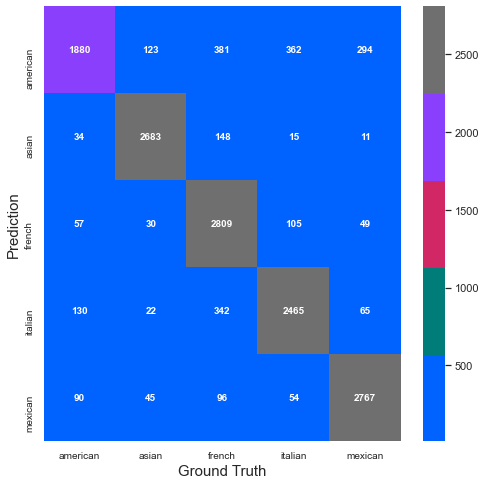

In [59]:
# build the decision tree using the parameters

dt = DecisionTreeClassifier(max_depth=101, max_features=351, random_state=0)

dt = dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('f1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

plot_confusion_matrix(y_test, y_pred, le)

**Last classification using Random Forest.I run the classification for different numbers of trees to evaluate the oob error.**

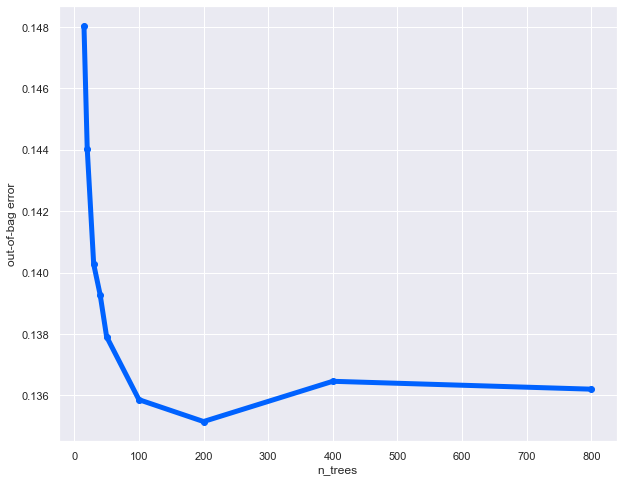

In [64]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=0, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 200, 400, 800]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(10, 8), linewidth=5)
ax.set(ylabel='out-of-bag error');

I decide to use n_estimators=200.

f1 score: 0.8683


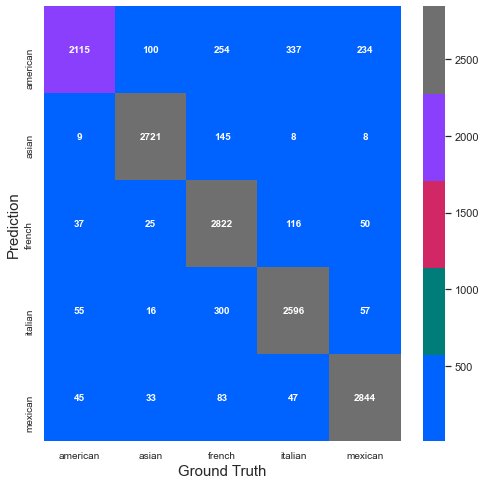

In [65]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=0, 
                            warm_start=True,
                            n_jobs=-1)

RF.set_params(n_estimators=200, warm_start=False)

RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

print('f1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

plot_confusion_matrix(y_test, y_pred, le)

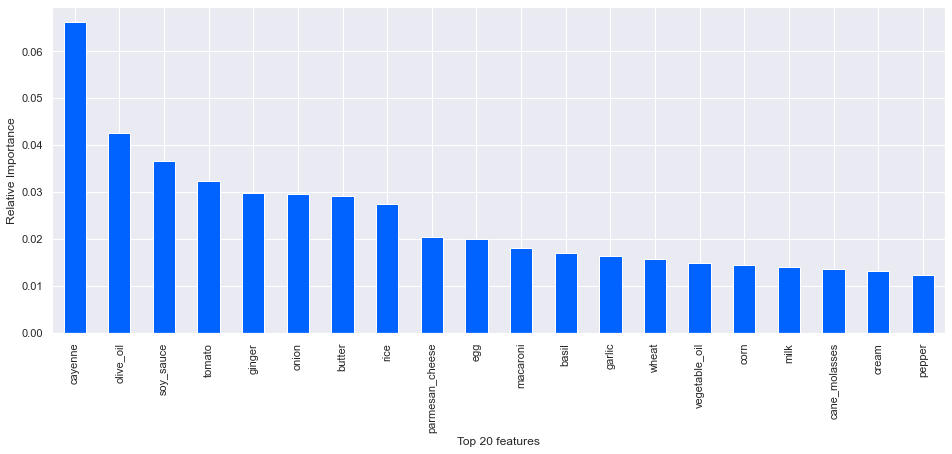

In [66]:
# plotting the feature importance for the top 20 features

feature_imp = pd.Series(RF.feature_importances_, index=X_test.columns.values).sort_values(ascending=False)

ax = feature_imp.sort_values(ascending=False)[0:20].plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance')
ax.set(xlabel='Top 20 features')
plt.show()